In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from psiam_tied_utils import psiam_tied_data_gen_wrapper, all_RTs_fit_fn, up_RTs_fit_fn, down_RTs_fit_fn, all_RTs_fit_OPTIM_fn

# params

In [5]:
# stim params
ABL_arr = [20]
ILD_arr = [0]

# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)
t_non_decision = 78e-3

V_A = 6
theta_A = 1

# t_stim = 0.25
# t_A_aff = 0.01
# t_E_aff = 0.02
# t_motor = 0.03
t_stim = 0
t_A_aff = 0.1
t_E_aff = 0.1
t_motor = 0.1

Z_E = 10

# sim params
N_sim = int(1e5)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [6]:
sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                            t_stim, t_A_aff, t_E_aff, t_motor, dt)\
                                                                                  for _ in range(N_sim))
# parse results
all_choice = np.array([res['choice'] for res in sim_results])
all_RT = np.array([res['rt'] for res in sim_results])
all_is_act = np.array([res['is_act'] for res in sim_results])


print(f"% of AI process = {100*np.sum(all_is_act)/N_sim}")
print(f"Num of Aborts = {np.sum(all_RT < t_stim)}")
print(f"Num of up hits = {np.sum(all_choice == 1)}, Num of down hits = {np.sum(all_choice == -1)}")

% of AI process = 48.554
Num of Aborts = 0
Num of up hits = 59939, Num of down hits = 40061


In [42]:
# import pickle
# with open('PSIAM_TIED_10M_sim_results.pkl', 'wb') as f:
#     pickle.dump(sim_results, f)

# sim + theory

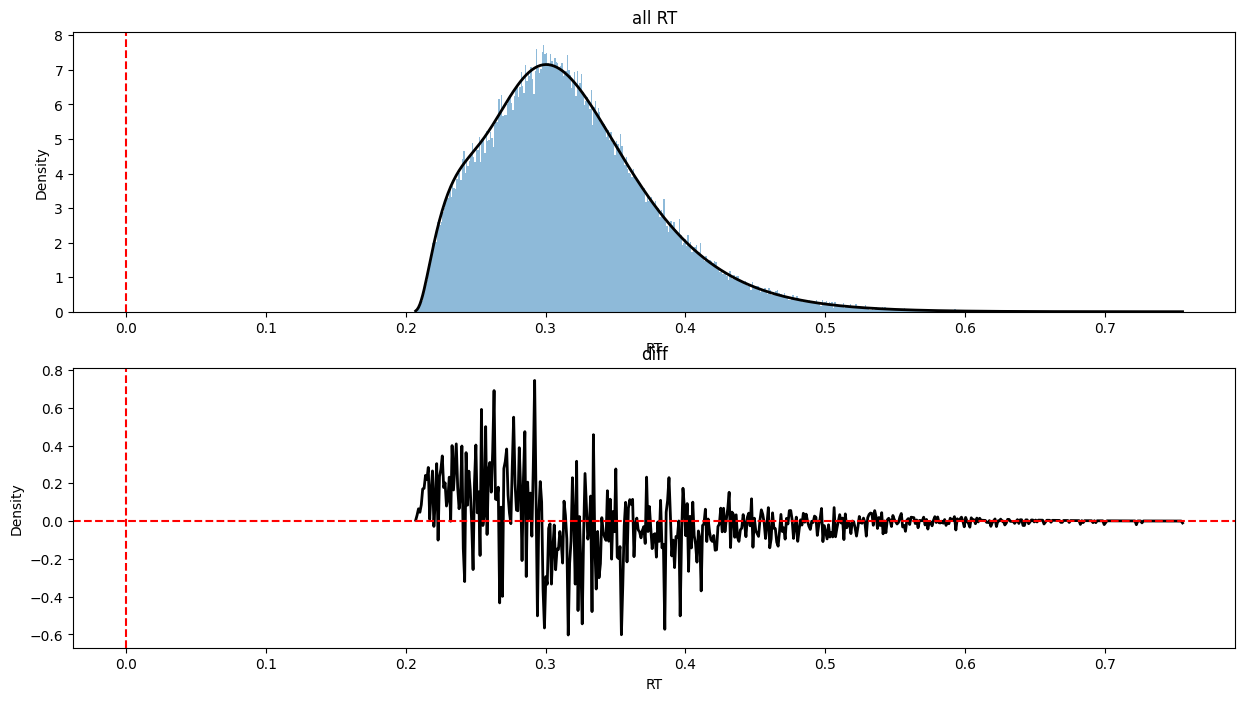

In [7]:
# stim
ABL = ABL_arr[0]; ILD = ILD_arr[0]

# bins
bin_width = 0.001  
bins = np.arange(min(all_RT), max(all_RT) + bin_width, bin_width)

# t_pts are midpoints of the bins
t_pts = bins[:-1] + bin_width/2
theory = all_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

all_hist, all_bins = np.histogram(all_RT, bins=bins, density=True)

plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(all_bins[:-1], all_hist, width=bin_width, alpha=0.5, label='all RT')
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, theory, 'k', lw=2);
plt.title('all RT');plt.xlabel('RT');plt.ylabel('Density');

plt.subplot(2,1,2)
diff_all = theory - all_hist 
plt.plot(t_pts, diff_all, 'k', lw=2);
plt.title('diff');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--');


# up rt

In [8]:
up_rt_idx = np.where(all_choice == 1)[0]
up_rt = all_RT[up_rt_idx]

non_abort_up_rt_idx = np.where(up_rt > t_stim)[0]
up_rt = up_rt[non_abort_up_rt_idx]

bin_width = 0.001
min_rt = np.min(up_rt)
max_rt = np.max(up_rt)

# hist
bins = np.arange(min_rt, max_rt + bin_width, bin_width)
up_hist, up_bins = np.histogram(up_rt, bins=bins, density=True)
up_hist *= len(up_rt)/( len(all_RT) )

# theory
t_pts = bins[:-1] + bin_width/2
ABL = ABL_arr[0]; ILD = ILD_arr[0]
up_theory = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

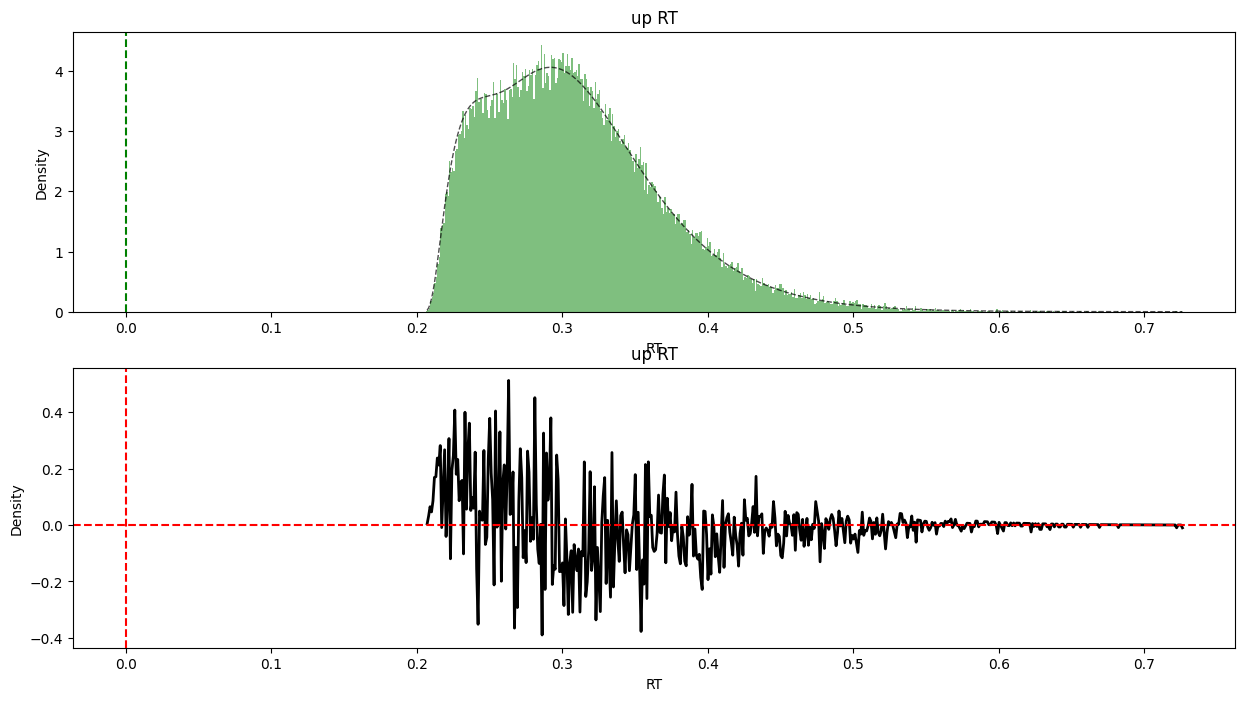

In [9]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(up_bins[:-1], up_hist, width=bin_width, color='g', alpha=0.5)
plt.axvline(x=t_stim, color='g', linestyle='--')
plt.plot(t_pts, up_theory, lw=1, linestyle='--', color='k', alpha=0.7);
plt.xlabel('RT');plt.ylabel('Density');plt.title('up RT');

plt.subplot(2,1,2)
diff_up = up_theory - up_hist
plt.plot(t_pts, diff_up, 'k', lw=2);
plt.title('up RT');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--');

# down rt

In [10]:
down_rt_idx = np.where(all_choice == -1)[0]
down_rt = all_RT[down_rt_idx]

non_abort_down_rt_idx = np.where(down_rt > t_stim)[0]
down_rt = down_rt[non_abort_down_rt_idx]

ABL = ABL_arr[0]; ILD = ILD_arr[0]


bin_width = 0.001
min_rt = np.min(down_rt)
max_rt = np.max(down_rt)
bins = np.arange(min_rt, max_rt + bin_width, bin_width)

down_hist, down_bins = np.histogram(down_rt, bins=bins, density=True)
down_hist *= len(down_rt)/( len(all_RT))


t_pts = bins[:-1] + bin_width/2
down_theory = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

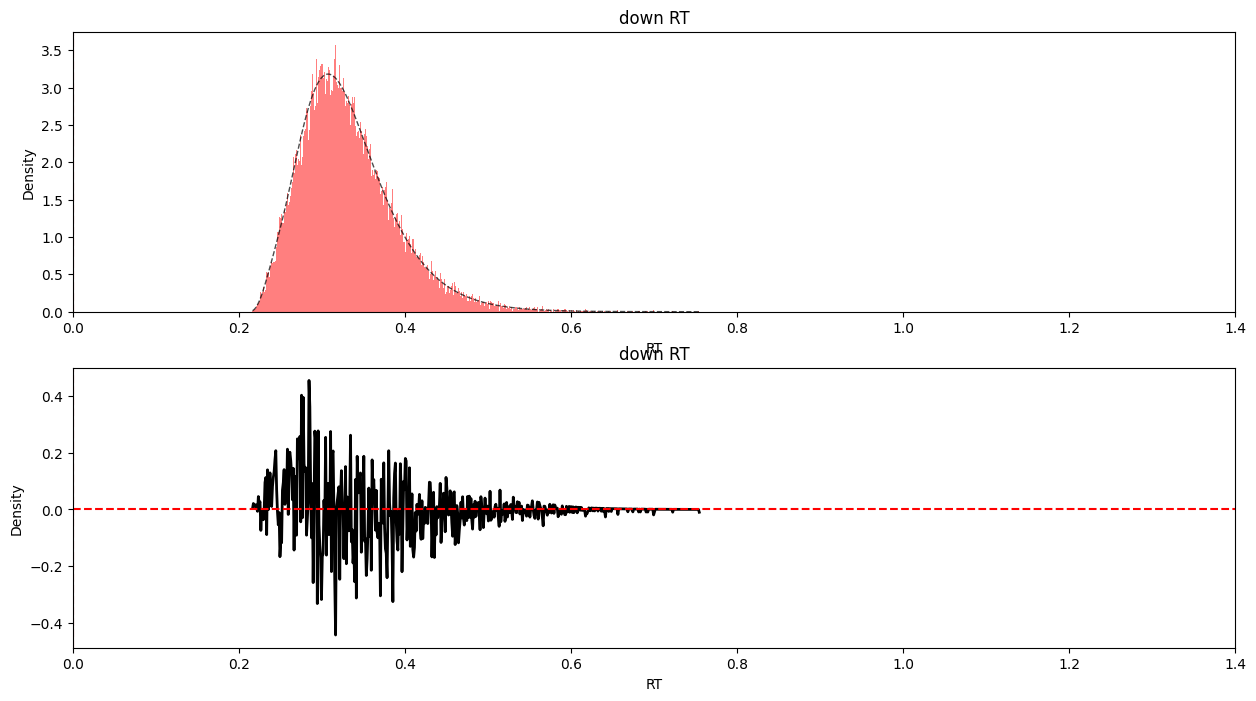

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(down_bins[:-1], down_hist, width=bin_width, color='r', alpha=0.5)
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, down_theory, 'k', lw=1, linestyle='--', alpha=0.7);
plt.xlim([0, 1.4]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');

plt.subplot(2,1,2)
diff_down = down_theory - down_hist
plt.plot(t_pts, diff_down, 'k', lw=2);
plt.title('down RT');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--') 
plt.xlim([0, 1.4]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');


# normalized theory curve

## up

In [98]:
from psiam_tied_utils import rho_A_t_fn, P_small_t_btn_x1_x2, CDF_E_minus_small_t_NORM_fn, rho_E_minus_small_t_NORM_fn, cum_A_t_fn
def up_RTs_fit_fn_single_t(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    
    bound = 1

    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)
    P_EA_btn_1_2 = P_small_t_btn_x1_x2(1, 2, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_plus_cum = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    P_E_plus = rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)

    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm

In [99]:
from scipy.integrate import quad

integ_const_up = quad(up_RTs_fit_fn_single_t, 0, np.inf, args=(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max))[0]

In [100]:
up_rt_idx = np.where(all_choice == 1)[0]
up_rt = all_RT[up_rt_idx]

non_abort_up_rt_idx = np.where(up_rt > t_stim)[0]
up_rt = up_rt[non_abort_up_rt_idx]


bin_width = 0.001  
min_rt = np.min(up_rt)
max_rt = np.max(up_rt)
bins = np.arange(min_rt, max_rt + bin_width, bin_width)

up_hist, up_bins = np.histogram(up_rt, bins=bins, density=True)

# up theory
t_pts = bins[:-1] + bin_width/2
up_theory_2 = np.array([up_RTs_fit_fn_single_t(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)/integ_const_up for t in t_pts])

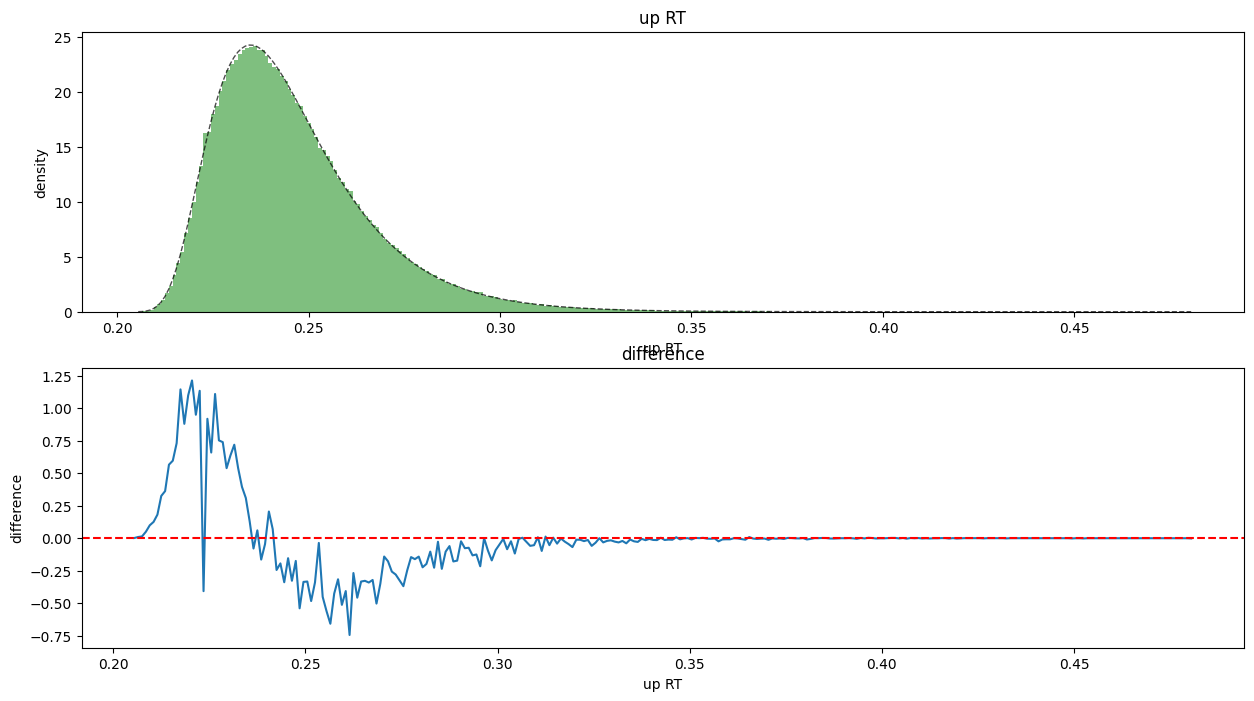

In [102]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.bar(up_bins[:-1], up_hist, width=bin_width, color='g', alpha=0.5)
plt.plot(t_pts, up_theory_2, 'k', lw=1, label = 'up RT theory', alpha=0.7, linestyle='--');
plt.xlabel('up RT');plt.ylabel('density');plt.title('up RT');

plt.subplot(2,1,2)
diff_up_2 = up_theory_2 - up_hist
plt.plot(t_pts, diff_up_2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('up RT');plt.ylabel('difference');plt.title('difference');


## down

In [103]:
def down_RTs_fit_fn_single_t(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    """
    PDF of down RTs array
    """
    bound = -1
        
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)
    P_EA_btn_0_1 = P_small_t_btn_x1_x2(0, 1, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_minus_cum = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    P_E_minus = rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)

    P_wrong_unnorm = (P_A*(P_EA_btn_0_1+P_E_minus_cum) + P_E_minus*(1-C_A))
    return P_wrong_unnorm

In [104]:
from scipy.integrate import quad

integ_const_2 = quad(down_RTs_fit_fn_single_t, 0, np.inf, args=(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max))[0]

In [105]:
down_rt_idx = np.where(all_choice == -1)[0]
down_rt = all_RT[down_rt_idx]

non_abort_down_rt_idx = np.where(down_rt > t_stim)[0]
down_rt = down_rt[non_abort_down_rt_idx]

bin_width = 0.001
min_rt = np.min(down_rt)
max_rt = np.max(down_rt)
bins = np.arange(min_rt, max_rt + bin_width, bin_width)

down_hist, down_bins = np.histogram(down_rt, bins=bins, density=True)

t_pts = bins[:-1] + bin_width/2
down_theory_2 = np.array([down_RTs_fit_fn_single_t(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)/integ_const_2 for t in t_pts])


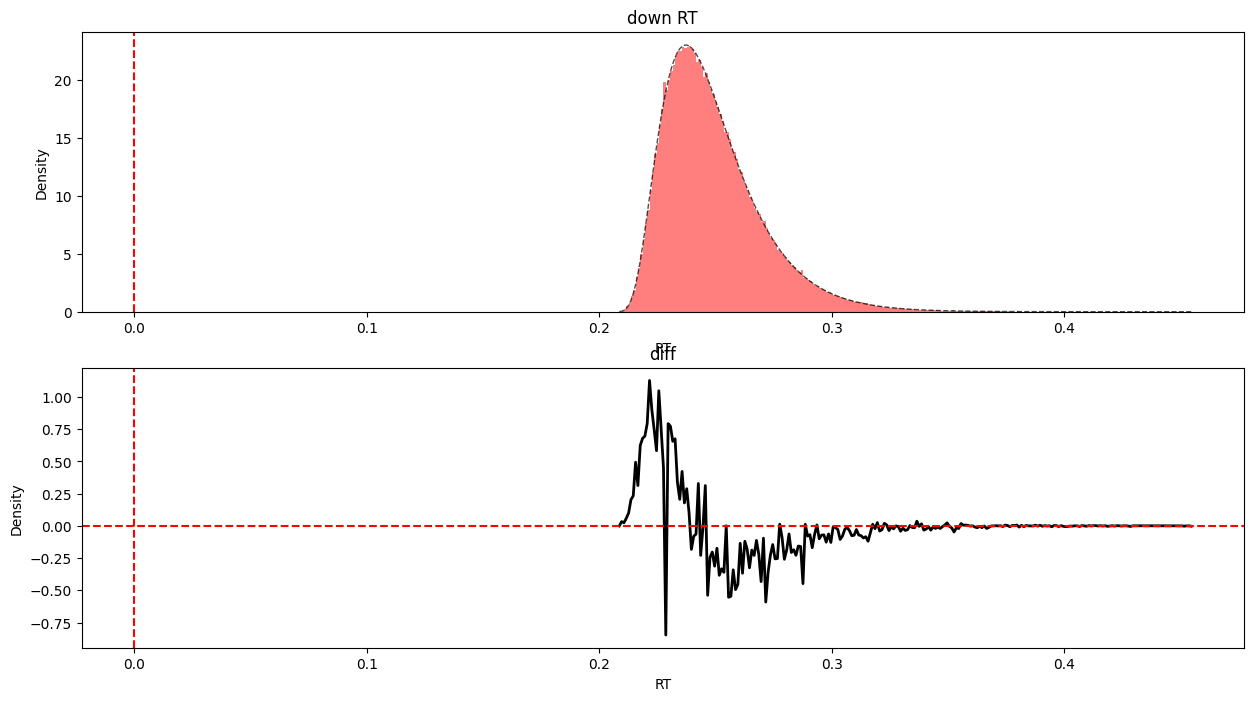

In [106]:
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.bar(down_bins[:-1], down_hist, width=bin_width, color='r', alpha=0.5)
plt.axvline(x=t_stim, color='r', linestyle='--')
plt.plot(t_pts, down_theory_2, 'k', lw=1, linestyle='--', alpha=0.7);
plt.xlabel('RT');plt.ylabel('Density');plt.title('down RT');

plt.subplot(2,1,2)
diff_down = down_theory_2 - down_hist
plt.plot(t_pts, diff_down, 'k', lw=2);
plt.title('diff');plt.xlabel('RT');plt.ylabel('Density');
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=t_stim, color='r', linestyle='--');

In [73]:
integ_const_up + integ_const_2

0.9999999999999527

# try fitting only AI

In [74]:
# take rt and choice of res whose is_act is True
choice_ai = []; rt_ai = []
for res in sim_results:
    if res['is_act']:
        choice_ai.append(res['choice'])
        rt_ai.append(res['rt'])

In [75]:
from psiam_tied_utils import rho_A_t_fn, CDF_E_minus_small_t_NORM_fn
def fit_ai_rt_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    """
    Fit the RT of AI process
    """
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) 
    C_E = CDF_E_minus_small_t_NORM_fn(t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
           + CDF_E_minus_small_t_NORM_fn(t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max) 
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_cum = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
                + CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, K_max)
    
    P_AI = P_A*((1-C_E)+P_E_cum)

    return P_AI


In [76]:
# norm term for AI process
from scipy.integrate import quad
norm_term_for_ai = quad(fit_ai_rt_fn, 0, np.inf, args=(V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max))[0]
print(f"Norm term for AI process is {norm_term_for_ai}")

Norm term for AI process is 0.8776145858641895


In [77]:
import math
ceil_max = math.ceil(max(rt_ai))
t_pts = np.linspace(0.001, ceil_max, ceil_max*100)

ai_theory = [fit_ai_rt_fn(t, V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)/norm_term_for_ai for t in t_pts]


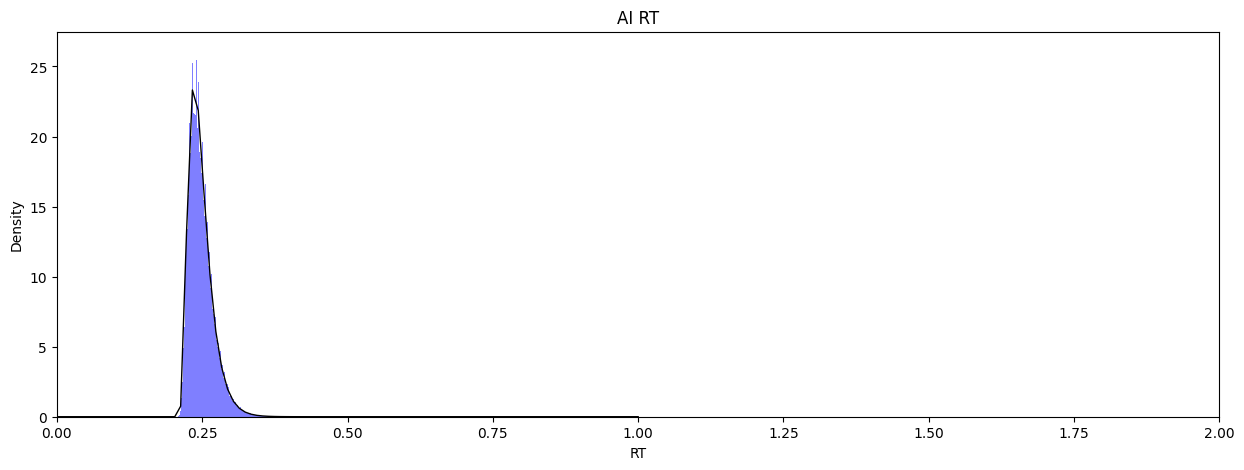

In [78]:
plt.figure(figsize=(15, 5))
plt.hist(rt_ai, bins=500, color='b', alpha=0.5, density=True);
plt.plot(t_pts, ai_theory, 'k', lw=1);
plt.xlim([0, 2]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('AI RT');

# ai up

get rts

In [79]:
# take rt and choice of res whose is_act is True
rt_ai_up = []
for res in sim_results:
    if res['is_act']:
        if res['choice'] == 1:
            if res['rt'] > t_stim:
                rt_ai_up.append(res['rt'])

func to fit up rt

In [80]:
from psiam_tied_utils import rho_A_t_fn, P_small_t_btn_x1_x2, CDF_E_minus_small_t_NORM_fn

def ai_up_rt_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    """
    PDF of up RTs array
    """
    bound = 1

    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)
    P_EA_btn_1_2 = P_small_t_btn_x1_x2(1, 2, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_plus_cum = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    
    return  (P_A*(P_EA_btn_1_2 + P_E_plus_cum))

norm term

In [81]:
# norm term for AI process
from scipy.integrate import quad
norm_term_for_ai_up = quad(ai_up_rt_fn, 0, np.inf, args=(V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max))[0]
print(f"Norm term for AI process is {norm_term_for_ai_up}")

Norm term for AI process is 0.4975607335698138


In [82]:
import math
ceil_max = math.ceil(max(rt_ai_up))
t_pts = np.linspace(0.001, ceil_max, ceil_max*1000)

ai_up_theory = [ai_up_rt_fn(t, V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)/norm_term_for_ai_up for t in t_pts]

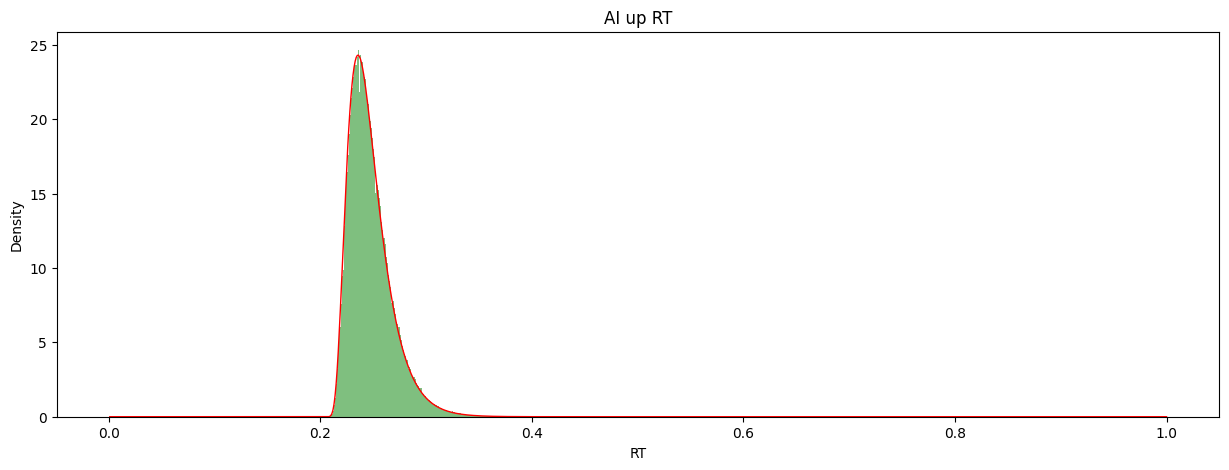

In [92]:
plt.figure(figsize=(15, 5))
plt.hist(rt_ai_up, bins=250, color='g', alpha=0.5, density=True);
plt.plot(t_pts, ai_up_theory, 'r', lw=1);
# plt.xlim([0, 2]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('AI up RT');

# ai down

get data

In [93]:
# take rt and choice of res whose is_act is True
rt_ai_down = []
for res in sim_results:
    if res['is_act']:
        if res['choice'] == -1:
            if res['rt'] > t_stim:
                rt_ai_down.append(res['rt'])

func to fit

In [94]:
from psiam_tied_utils import rho_A_t_fn, P_small_t_btn_x1_x2, CDF_E_minus_small_t_NORM_fn
def ai_rt_down_fit_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    """
    PDF of down RTs array
    """
    bound = -1
        
    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)
    P_EA_btn_0_1 = P_small_t_btn_x1_x2(0, 1, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    if t1 < 0:
        t1 = 0
    P_E_minus_cum = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    P_wrong_unnorm = (P_A*(P_EA_btn_0_1+P_E_minus_cum))
    return P_wrong_unnorm

norm term

In [95]:
# norm term
from scipy.integrate import quad

norm_term_for_ai_down = quad(ai_rt_down_fit_fn, 0, np.inf, args=(V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max))[0]
print(f"Norm term for AI process is {norm_term_for_ai_down}")

Norm term for AI process is 0.3800538522943755


fit data

In [96]:
import math

ceil_max = math.ceil(max(rt_ai_down))
t_pts = np.linspace(0.001, ceil_max, ceil_max*1000)

ai_down_theory = [ai_rt_down_fit_fn(t, V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)/norm_term_for_ai_down for t in t_pts]

plot

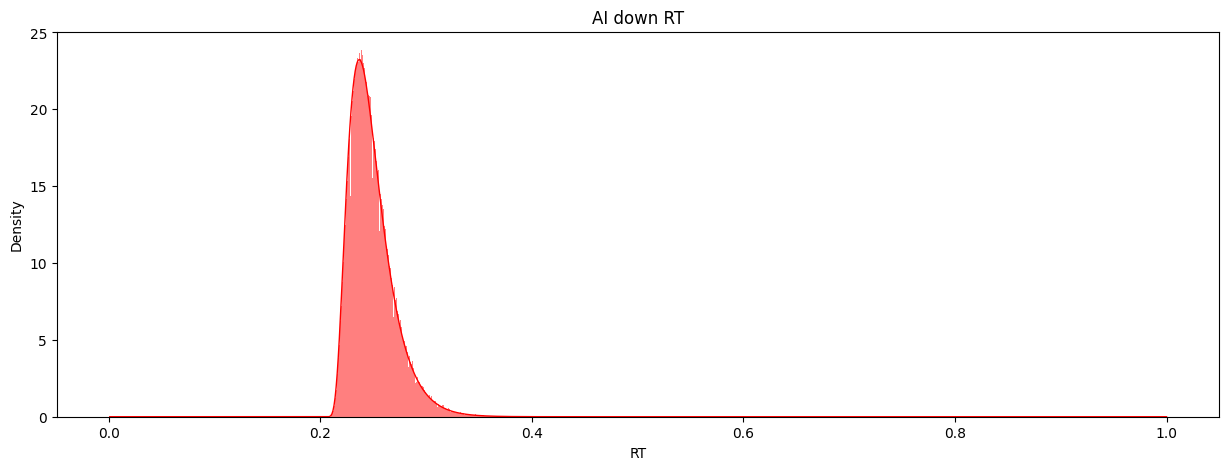

In [97]:
plt.figure(figsize=(15, 5))
plt.hist(rt_ai_down, bins=500, color='r', alpha=0.5, density=True);
plt.plot(t_pts, ai_down_theory, 'r', lw=1);
# plt.xlim([0, 2]);
plt.xlabel('RT');plt.ylabel('Density');plt.title('AI down RT');

# EA up

get data

In [89]:
rt_ea_up = []
for res in sim_results:
    if res['is_act'] == 0:
        if res['choice'] == 1:
            if res['rt'] > t_stim:
                rt_ea_up.append(res['rt'])

func to fit

In [90]:
def ea_up_RTs_fit_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    """
    PDF of up RTs array
    """
    bound = 1

    P_E_plus = rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)

    P_correct_unnorm = (P_E_plus*(1-C_A))
    return P_correct_unnorm